In [1]:
import pandas as pd
import numpy as np
from WindPy import w
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
%matplotlib inline

In [2]:
w.start()

Welcome to use Wind Quant API for Python (WindPy)!
You can use w.menu to help yourself to create commands(WSD,WSS,WST,WSI,WSQ,...)!

COPYRIGHT (C) 2016 WIND HONGHUI INFORMATION & TECHKNOLEWDGE CO., LTD. ALL RIGHTS RESERVED.
IN NO CIRCUMSTANCE SHALL WIND BE RESPONSIBLE FOR ANY DAMAGES OR LOSSES CAUSED BY USING WIND QUANT API FOR Python.


.ErrorCode=0
.Data=[OK!]

In [3]:
index = '000001.SH'
start_date = '2012-03-01'
end_date = '2017-05-01'
field = 'close,high,low'

In [4]:
def wind2df(raw_data):
    dic = {}
    for data, field in zip(raw_data.Data, raw_data.Fields):
        dic[str(field.lower())] = data
    return pd.DataFrame(dic, index=raw_data.Times)

In [5]:
data = w.wsd(index, field, start_date, end_date)

In [6]:
df = wind2df(data)

In [7]:
df.head()

,close,high,low
2012-03-01 00:00:00.005,2426.115,2437.874,2418.334
2012-03-02 00:00:00.005,2460.693,2461.121,2430.098
2012-03-05 00:00:00.005,2445.002,2469.841,2442.115
2012-03-06 00:00:00.005,2410.445,2442.001,2406.056
2012-03-07 00:00:00.005,2394.794,2413.695,2388.519


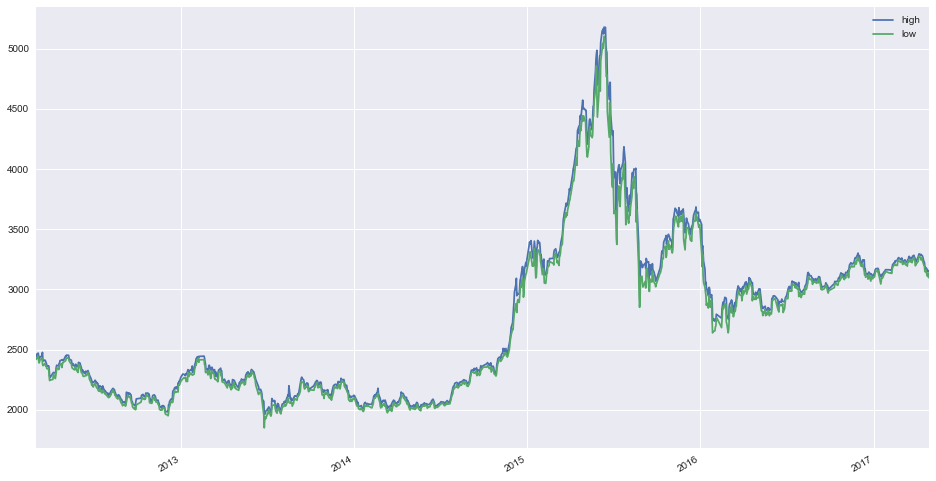

In [8]:
plt.figure(figsize=(16, 9))
df['high'].plot()
df['low'].plot()
plt.legend()

In [9]:
df['ratio'] = df['high'] / df['low']

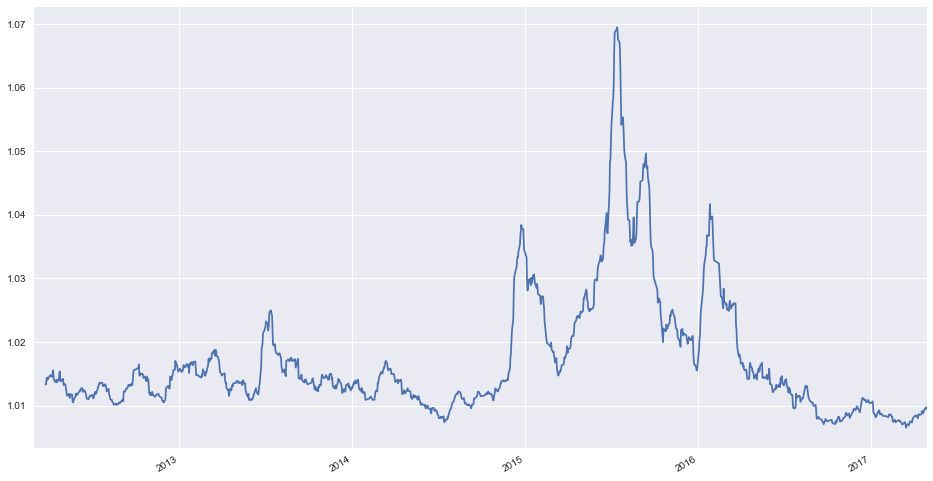

In [10]:
plt.figure(figsize=(16, 9))
df['ratio'].rolling(window=18).mean().plot()

In [127]:
def roll(df, w):
    """
    This fucntion comes from:
    http://stackoverflow.com/questions/37486502/why-does-pandas-rolling-use-single-dimension-ndarray/37491779#37491779
    """
    df.fillna(df.mean(), inplace=True)
    roll_array = np.dstack([df.values[i:i+w, :] for i in range(len(df.index) - w + 1)]).T
    panel = pd.Panel(roll_array,
                     items=df.index[w-1:],
                     major_axis=df.columns,
                     minor_axis=pd.Index(range(w), name='roll'))
    return panel.to_frame().unstack().T.groupby(level=0)

In [ ]:
rolled_df = roll(df, 18)

In [104]:
def calculate(df):
    y, X = df['high'].values, df['low'].values
    sm.add_constant(X)
    model = sm.OLS(y, X)
    results = model.fit()
    return results.params[0]

In [105]:
rsrs = rolled_df.apply(calculate)

2016-03-24 00:00:00.005    1.019883
2016-03-25 00:00:00.005    1.018764
2016-03-28 00:00:00.005    1.017784
2016-03-29 00:00:00.005    1.018059
2016-03-30 00:00:00.005    1.017775
dtype: float64


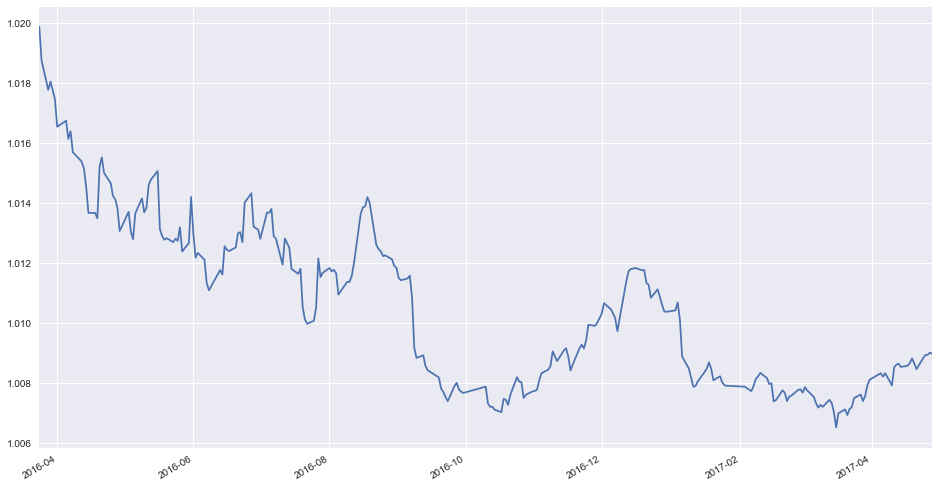

In [109]:
plt.figure(figsize=(16, 9))
rsrs.plot()

In [11]:
df['ret'] = df['close'].pct_change(20).shift(-20)
df['rsrs'] = df['ratio'].rolling(window=10).mean()

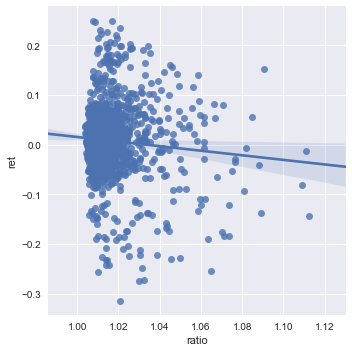

In [12]:
sns.lmplot(x='ratio', y='ret', data=df)

In [13]:
df['rsrs score'] = df['rsrs'].rolling(window=18).apply(lambda x: (x[-1] - x.mean()) / x.std())

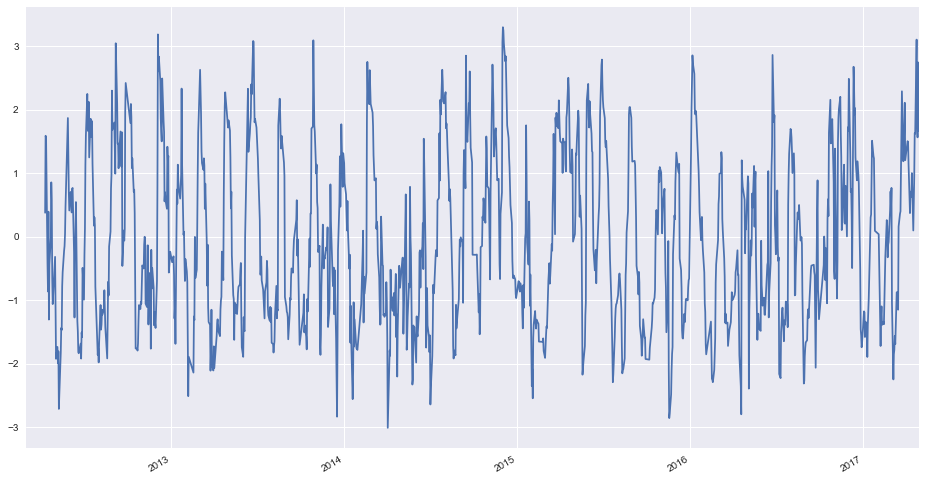

In [14]:
plt.figure(figsize=(16, 9))
df['rsrs score'].plot()

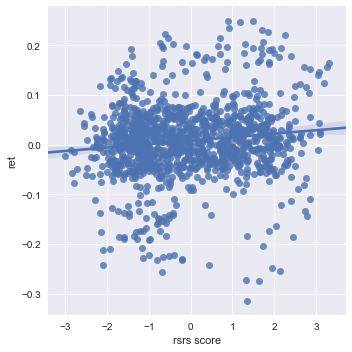

In [15]:
sns.lmplot(x='rsrs score', y='ret', data=df)